# Track and summarize experimental data from 20231012

In [1]:
import os
import glob
import numpy as np
import traceback
import dclab
import dctrack

# supress warning from skimage
import warnings
warnings.filterwarnings( 
    "ignore", message="divide by zero encountered in scalar divide")
warnings.filterwarnings(
    "ignore", message="invalid value encountered in scalar divide")
warnings.filterwarnings(
    "ignore", message="Polyfit may be poorly conditioned")
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", message="The fit may be poorly conditioned")

C:\Users\freiche\ownCloud\PhD\Code_general\rtdc_tracking2.0\dctrack\track.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
project_folder = r"..\..\raw_data\20231012_Felix_HL60_LatB_Noco_hyper"
export_folder = r"..\..\tracked_data"

In [3]:
# length of hyperbolic region in um
length_hyper_region = 500
frame_max = None
timeout = None  # 1h 30m

for root, _, _ in os.walk(project_folder):
    if not "tracked_files" in root:
        rtdc_paths = glob.glob(os.path.join(root,"*.rtdc"))
        for file in rtdc_paths:
            print("Analyzing {} \n".format(file))
            # create directory with same structure as Data/RTDC to export data
            file_split = file.split("\\")
            rtdc_idx = file_split.index("RTDC")
            subfolders_export = np.array(file_split)[rtdc_idx+1:-1]
            save_folder = os.path.join(export_folder,"\\".join(subfolders_export))
            if not os.path.isdir(save_folder):
                os.makedirs(save_folder)
            video_folder = os.path.join(save_folder,"Videos")
            if not os.path.isdir(video_folder):
                os.makedirs(video_folder)

            save_path = os.path.join(save_folder, file_split[-1])
            if not os.path.isfile(save_path):
                try:
                    ds = dclab.new_dataset(file)
                    tr_ds = dctrack.track.TrackedDataSet(ds)

                    pix_size = tr_ds.pixel_size
                    tr_ds.tolerance_window = 30

                    tr_ds.channel = True
                    tr_ds.outlet = False
                    if "inlet" in file:
                        tr_ds.inlet = False
                        channel_entry = tr_ds.channel_x_min - 500/pix_size
                        tr_ds.set_channel_values_manual(x_min=0,
                                                        x_max=tr_ds.roi_size_x)
                    else:
                        tr_ds.inlet = True
                        # ROI start 50 um before channel start
                        channel_entry = tr_ds.channel_x_min + 50/pix_size
                        tr_ds.set_channel_values_manual(x_min=0,
                                                        x_max=channel_entry)
                    # start of hyperbolic region in um
                    hyper_start = channel_entry*pix_size + length_hyper_region

                    tr_ds.track(frame_min=0, frame_max=frame_max,
                                timeout=timeout,
                                max_skip_frames=8)
                    tr_ds.time_after_x(hyper_start, return_value=False,
                                       add_to_dataset=True,
                                       variable_name='time_hyper_region')
                    tr_ds.get_ellipse_data(show_progress=False)

                    frame_tracked = tr_ds.dataset['frame'][:][~np.isnan(tr_ds.dataset['object_number'][:])]
                    tr_ds.filter_feature('frame', 0, frame_tracked[-1])

                    export_features = tr_ds.dataset.features_scalar
                    if 'inert_ratio_raw' not in export_features:
                        export_features += ['inert_ratio_raw', 'inert_ratio_cvx']
                    tr_ds.export_tracked_dataset_as_hdf5(path=save_path,
                                                         features=export_features,
                                                         filtered=True,
                                                         override=True,
                                                         compression=None,
                                                         skip_checks=True)

                    video_path = os.path.join(video_folder, os.path.splitext(file_split[-1])[0]+".avi")
                    tr_ds.write_video(save_path=video_path, first_frame=1000, last_frame=3000,
                                      draw_zones=True)
                except:
                    print("An error occured. See below \n")
                    print(traceback.print_exc())

Analyzing Y:\Data\RTDC\20231012_Felix_HL60_LatB_Noco_hyper\1um_Noco\hyper\M001_data.rtdc 

Analyzing Y:\Data\RTDC\20231012_Felix_HL60_LatB_Noco_hyper\1um_Noco\hyper\M002_data.rtdc 

Analyzing Y:\Data\RTDC\20231012_Felix_HL60_LatB_Noco_hyper\1um_Noco\hyper\M003_data.rtdc 

Analyzing Y:\Data\RTDC\20231012_Felix_HL60_LatB_Noco_hyper\1um_Noco\inlet\M001_data.rtdc 

Analyzing Y:\Data\RTDC\20231012_Felix_HL60_LatB_Noco_hyper\250nM_LatB\hyper\M001_data.rtdc 

Analyzing Y:\Data\RTDC\20231012_Felix_HL60_LatB_Noco_hyper\250nM_LatB\hyper\M002_data.rtdc 

Analyzing Y:\Data\RTDC\20231012_Felix_HL60_LatB_Noco_hyper\250nM_LatB\hyper\M003_data.rtdc 

Analyzing Y:\Data\RTDC\20231012_Felix_HL60_LatB_Noco_hyper\250nM_LatB\inlet\M001_data.rtdc 

Analyzing Y:\Data\RTDC\20231012_Felix_HL60_LatB_Noco_hyper\250nM_LatB_1uM_Noco\hyper\M001_data.rtdc 

Analyzing Y:\Data\RTDC\20231012_Felix_HL60_LatB_Noco_hyper\250nM_LatB_1uM_Noco\hyper\M002_data.rtdc 

Analyzing Y:\Data\RTDC\20231012_Felix_HL60_LatB_Noco_hyper\2

Tracking in progress:   0%|          | 0/4844 [00:00<?, ?it/s]

Computing velocities:   0%|          | 0/476 [00:00<?, ?it/s]

Writing video:   0%|          | 0/2000 [00:00<?, ?it/s]

## Summarize results

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
sns.set_context('talk')
from tqdm.notebook import tqdm
from scripts.stress_hyper import (shear_stress_hyper_wc60_lc500_ell_20230816,
                                  normal_stress_hyper_wc60_lc500_ell_20230817,
                                  total_stress_hyper_wc60_lc500_ell_20230817,
                                  total_stress_hyper_wc60_lc500_20230801,
                                  shear_stress_hyper_wc60_lc500_20230801,
                                  normal_stress_hyper_wc60_lc500_20230621)
from scripts.extensional_paras import (fit_velocity,
                                       extension_rate_from_velocity_poly,
                                       recalculate_time)

In [5]:
# for some reason need to re-register the ellipse features
ell_features = ['ell_cx', 'ell_cy', 'ell_major', 'ell_minor', 'ell_angle']
for ell_feat in ell_features:
    if not dclab.definitions.feature_exists(ell_feat):
        dclab.register_temporary_feature(feature=ell_feat)

In [6]:
def compute_extensional_paras(tr_ds,
                              hyper_start=None, hyper_end=None,
                              stable_region_start=None,
                              filter=False, **filter_kws):
    """
    :param tr_ds: tracked_dataset instance of dctrack
    :return: df: dataframe with additional analysis parameters
    """
    if filter:
        tr_ds.filter_obj_distance = True
        tr_ds.filter_obj_n_events = True
        tr_ds.filter_backward_movement = True
        tr_ds.filter(inplace=True, return_filtered_ds=False, **filter_kws)

    df = tr_ds.get_extensional_paras_dataframe(hyper_start=hyper_start,
                                               hyper_end=hyper_end,
                                               stable_extension_start=stable_region_start
                                               )
    return df

def get_folder_data(folder):
    # print("Analyzing ", folder)
    files = glob.glob(os.path.join(folder, "*.rtdc"))

    df_folder = pd.DataFrame()

    for file in tqdm(files):
        tr_ds = dctrack.track.TrackedDataSet(file)
        flow_rate = np.round(tr_ds.dataset.config['setup']['flow rate'], 2)
        # hyperbola start 500 um before channel
        hyper_start = tr_ds.channel_x_max * tr_ds.pixel_size + 500
        # stable region 100 µm in the hyperbola
        # (flow right to left -> negative sign)
        stable_region_start = hyper_start - 150

        df = compute_extensional_paras(tr_ds,
                                       hyper_start=hyper_start,
                                       stable_region_start=stable_region_start,
                                       filter=True,
                                       max_back_movement=0,
                                       min_events=5)

        # only use data in linear regime for fitting
        df_filtered = df[(150 < df['x_hyper']) & (df['x_hyper'] < 450)]
        x_fit = np.array(df_filtered['x_hyper']) *1e-6 #  in m
        y_fit = np.array(df_filtered['velocity'])
        idx = np.isfinite(x_fit) & np.isfinite(y_fit)
        p, cov = np.polyfit(x_fit[idx], y_fit[idx], 1, cov=True)
        fit_errs = np.sqrt(np.diag(cov))

        df['extension_rate_sample'] = abs(p[0])
        df['extension_rate_sample_err'] = fit_errs[0]
        df['flow_rate'] = flow_rate

        roi_size_x = tr_ds.dataset.config['imaging']['roi size x']
        pix_size = tr_ds.dataset.config['imaging']['pixel size']
        df['pos_x_center'] = df['pos_x'] - roi_size_x * pix_size / 2

        df_folder = pd.concat([df_folder, df])

    return df_folder

def df_fit_values(df_in, x_feature='x_shift', time_label='time_shift', poly_degree=7, x_0=-60,
                  pixel_size=0.68):
    df_temp = df_in.copy()
    df_out = pd.DataFrame()
    flow_rates = df_temp['flow_rate'].unique()
    pbar = tqdm(flow_rates, desc="Iterating over flow_rates")
    for fr in pbar:
        df = df_temp[df_temp['flow_rate'] == fr].copy()
        df['x_shift'] = df['x_hyper'] - x_0
        x = df[x_feature]
        velocity_poly = fit_velocity(df, x_feature=x_feature, degree=poly_degree)
        df['velocity_fit'] = velocity_poly(x)
        er = extension_rate_from_velocity_poly(x, velocity_poly)
        df['extension_rate_fit'] = er
        df = recalculate_time(df, velocity_poly,
                              x_feature=x_feature,
                              time_label=time_label)
        # repeat time calculation for x_hyper -> time_hyper
        velocity_poly = fit_velocity(df, x_feature='x_hyper', degree=poly_degree)
        df = recalculate_time(df, velocity_poly,
                              x_feature='x_hyper',
                              time_label='time_hyper')
        df_out = pd.concat([df_out, df])

    extension_rate = df_out['extension_rate_fit']
    pos_x = df_out['x_hyper']
    # calculate diameter from ellipse fit
    # ellipse features calculated in pixels
    diameter = 2 * np.sqrt(pixel_size**2 * df_out['ell_major'] * df_out['ell_minor'])
    flow_rate = df_out['flow_rate']

    df_out['stress_ir'] = total_stress_hyper_wc60_lc500_20230801(extension_rate,
                                                                 pos_x,
                                                                 diameter,
                                                                 flow_rate)
    df_out['shear_stress_ir'] = shear_stress_hyper_wc60_lc500_20230801(pos_x,
                                                                       diameter,
                                                                       flow_rate)
    df_out['normal_stress_ir'] = normal_stress_hyper_wc60_lc500_20230621(extension_rate)
    df_out['stress_ell'] = total_stress_hyper_wc60_lc500_ell_20230817(
        extension_rate, pos_x, diameter, flow_rate)
    df_out['shear_stress_ell'] = shear_stress_hyper_wc60_lc500_ell_20230816(
        pos_x, diameter, flow_rate)
    df_out['normal_stress_ell'] \
        = normal_stress_hyper_wc60_lc500_ell_20230817(extension_rate)

    return df_out

In [7]:
project_folder = r"T:\Members\Felix\analysis_data\RTDC\20231012_Felix_HL60_LatB_Noco_hyper"
folder_names = ["DMSO",
                "250nM_LatB",
                "250nM_LatB_1uM_Noco",
                "1uM_Noco"
                ]

In [8]:
data_exports = r"..\data_exports"

In [9]:
data_folder = os.path.join(data_exports, "20231012_HL60_LatB_Noco", "exports_20231016")
if not os.path.isdir(data_folder):
    os.makedirs(data_folder)

##### Create and save one dataframe for all hyper data from 20231012
Need to create individual files for each sample because loop breaks often.

In [10]:
x0 = -50

In [11]:
for folder in tqdm(folder_names):
    print("Analyzing: ", folder)
    save_path = os.path.join(data_folder, folder + "_hyper.tsv")

    if not os.path.isfile(save_path):
        data_dir = os.path.join(project_folder, folder, "hyper")
        df_cc = get_folder_data(data_dir)

        df_cc = df_fit_values(df_cc[df_cc['x_hyper'] < 520].copy(), x_0=x0)
        df_cc['sample'] = folder

        df_cc.to_csv(save_path, sep='\t')

  0%|          | 0/4 [00:00<?, ?it/s]

Analyzing:  DMSO
Analyzing:  250nM_LatB
Analyzing:  250nM_LatB_1uM_Noco
Analyzing:  1uM_Noco


In [12]:
df_20231012 = pd.DataFrame()
files_20231012 = glob.glob(os.path.join(data_folder, "*hyper.tsv"))
for file in tqdm(files_20231012):
    df_cc = pd.read_csv(os.path.join(data_folder, file), sep='\t', index_col=0)
    df_20231012 = pd.concat([df_20231012, df_cc], ignore_index=True)

  0%|          | 0/4 [00:00<?, ?it/s]

In [13]:
# df_20230914.drop(columns=['Unnamed: 0'], inplace=True)
df_20231012['date'] = '20231012'
df_20231012['wc'] = 60
df_20231012['strain_inert'] = df_20231012['inert_ratio_raw'] - 1
# net tensile strain based on inertia ratio assuming shape is an ellipse
df_20231012['net_strain_inert'] = ((df_20231012['inert_ratio_raw'] - 1)
                                   / np.sqrt(df_20231012['inert_ratio_raw']))
# ellipse features
df_20231012['net_strain_ell'] = (df_20231012['ell_major'] - df_20231012['ell_minor']) \
                                / np.sqrt(df_20231012['ell_major'] * df_20231012['ell_minor'])
df_20231012['taylor_strain_ell'] = (df_20231012['ell_major'] - df_20231012['ell_minor']) \
                                   / (df_20231012['ell_major'] + df_20231012['ell_minor'])

In [14]:
filename = "20231012_hl60_latb_noco_hyper.tsv"
df_20231012.to_csv(os.path.join(data_exports, "20231012_HL60_LatB_Noco", filename),
                   sep='\t')
print("Done")

Done


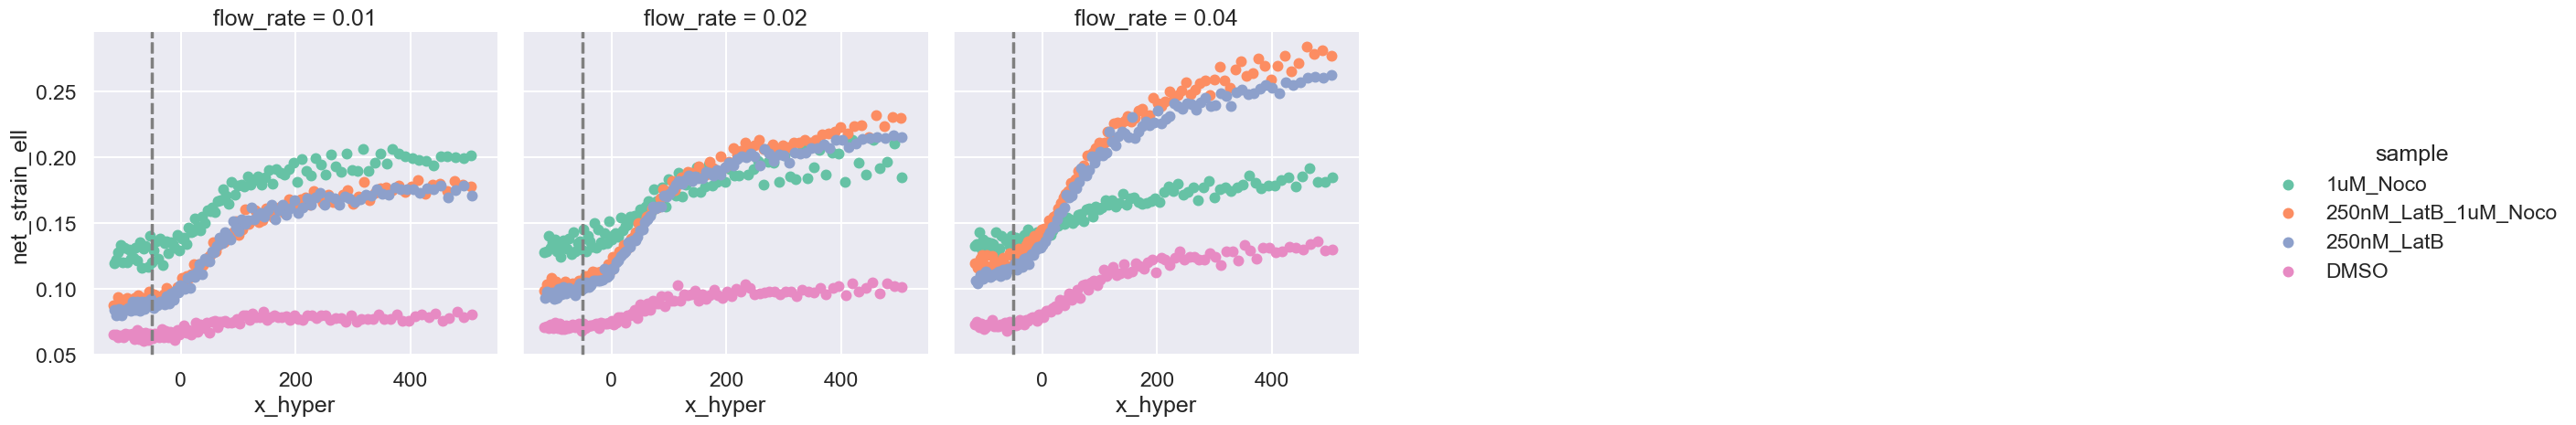

In [15]:
g = sns.lmplot(data=df_20231012,
               x='x_hyper', y='net_strain_ell', hue='sample', palette='Set2',
               col='flow_rate', col_wrap=5,
               x_bins=100, x_estimator=np.median, fit_reg=False, ci=None,
               facet_kws={'sharey': True})
g.refline(x=x0, markersize=0)
plt.show()

In [16]:
df_20231012

area_msd  area_ratio     area_um    aspect  bright_avg  bright_sd  \
0          314.0    1.079618  156.753600  0.916667  123.886955  22.269403   
1          311.5    1.077047  155.135210  0.956522  122.349850  21.957420   
2          315.0    1.071428  156.060010  0.956522  123.234100  22.185766   
3          313.0    1.073482  155.366410  0.913044  122.678260  23.204403   
4          311.0    1.075563  154.672800  0.954545  123.110466  23.294487   
...          ...         ...         ...       ...         ...        ...   
642155     363.0    1.035813  173.862410  1.090909  119.443040  28.689144   
642156     238.0    1.046218  115.137600  1.166667  119.231064  25.502443   
642157     237.5    1.029474  113.056810  1.111111  118.543724  25.778470   
642158     238.5    1.046122  115.368805  1.111111  118.977356  25.673264   
642159     236.5    1.057082  115.600006  1.222222  119.307980  26.869354   

            circ    deform  ell_angle      ell_cx  ...  stress_ell  \
0       0.961639  0.038361   1.485851  572.202128  ...    6.936743   
1       0.963120  0.036880   1.714519  478.954689  ...    6.941680   
2       0.966689  0.033311   1.770567  443.716338  ...    6.956844   
3       0.959585  0.040415   2.123923  324.931516  ...    7.157812   
4       0.960041  0.039959   2.197960  280.670949  ...    7.280760   
...          ...       ...        ...         ...  ...         ...   
642155  0.987241  0.012759   0.348378   91.426891  ...   33.641061   
642156  0.979938  0.020062   0.015861  259.212027  ...   31.010102   
642157  0.981419  0.018581   0.055062  204.967283  ...   30.792629   
642158  0.984077  0.015923   0.006037  147.749571  ...   29.677551   
642159  0.968429  0.031571   3.128347   87.500291  ...   27.523973   

        shear_stress_ell  normal_stress_ell    sample      date  wc  \
0               1.430172           5.506571  1uM_Noco  20231012  60   
1               1.878730           5.062950  1uM_Noco  20231012  60   
2               2.083508           4.873336  1uM_Noco  20231012  60   
3               2.667002           4.490809  1uM_Noco  20231012  60   
4               2.875873           4.404887  1uM_Noco  20231012  60   
...                  ...                ...       ...       ...  ..   
642155         17.522538          16.118523      DMSO  20231012  60   
642156          9.007857          22.002245      DMSO  20231012  60   
642157          9.802705          20.989923      DMSO  20231012  60   
642158         10.707121          18.970430      DMSO  20231012  60   
642159         11.616272          15.907701      DMSO  20231012  60   

        strain_inert  net_strain_inert  net_strain_ell  taylor_strain_ell  
0          -0.075178         -0.078173        0.085773           0.042847  
1          -0.055453         -0.057058        0.064486           0.032226  
2          -0.069108         -0.071627        0.070932           0.035444  
3          -0.051098         -0.052456        0.110185           0.055009  
4          -0.038337         -0.039093        0.110805           0.055318  
...              ...               ...             ...                ...  
642155      0.029794          0.029360        0.039047           0.019520  
642156      0.158759          0.147483        0.145814           0.072714  
642157      0.123843          0.116821        0.114494           0.057153  
642158      0.139780          0.130928        0.129199           0.064465  
642159      0.193950          0.177499        0.185287           0.092248  

[642160 rows x 67 columns]

### Summarize inlet data

In [17]:
def get_folder_data_inlet(folder):
    # print("Analyzing ", folder)
    files = glob.glob(os.path.join(folder, "*.rtdc"))

    df_folder = pd.DataFrame()

    for file in tqdm(files):
        tr_ds = dctrack.track.TrackedDataSet(file)
        flow_rate = np.round(tr_ds.dataset.config['setup']['flow rate'], 3)
        # hyperbola start 500 um before channel
        hyper_start = tr_ds.channel_x_min * tr_ds.pixel_size - 500

        df = compute_extensional_paras(tr_ds,
                                       hyper_start=hyper_start,
                                       filter=True,
                                       max_back_movement=0,
                                       min_events=5)
        df['flow_rate'] = flow_rate
        roi_size_x = tr_ds.dataset.config['imaging']['roi size x']
        pix_size = tr_ds.dataset.config['imaging']['pixel size']
        df['pos_x_center'] = df['pos_x'] - roi_size_x * pix_size / 2

        df_folder = pd.concat([df_folder, df])

    return df_folder

In [18]:
for folder in tqdm(folder_names):
    print("Analyzing: ", folder)
    save_path = os.path.join(data_folder, folder + "_inlet.tsv")

    if not os.path.isfile(save_path):
        data_dir = os.path.join(project_folder, folder, "inlet")
        df_cc = get_folder_data_inlet(data_dir)
        df_cc = df_fit_values(df_cc, x_0=x0)
        df_cc['sample'] = folder
        df_cc.to_csv(save_path, sep='\t')

  0%|          | 0/4 [00:00<?, ?it/s]

Analyzing:  DMSO


  0%|          | 0/1 [00:00<?, ?it/s]

Iterating over flow_rates:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing:  250nM_LatB


  0%|          | 0/1 [00:00<?, ?it/s]

Iterating over flow_rates:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing:  250nM_LatB_1uM_Noco


  0%|          | 0/1 [00:00<?, ?it/s]

Iterating over flow_rates:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing:  1uM_Noco


  0%|          | 0/1 [00:00<?, ?it/s]

Iterating over flow_rates:   0%|          | 0/1 [00:00<?, ?it/s]

In [19]:
df_20231012_inlet = pd.DataFrame()
files_20231012_inlet = glob.glob(os.path.join(data_folder, "*inlet.tsv"))
for file in tqdm(files_20231012_inlet):
    df_cc = pd.read_csv(os.path.join(data_folder, file), sep='\t', index_col=0)
    df_20231012_inlet = pd.concat([df_20231012_inlet, df_cc], ignore_index=True)

  0%|          | 0/4 [00:00<?, ?it/s]

In [20]:
# df_20230914_inlet.drop(columns=['Unnamed: 0'], inplace=True)
df_20231012_inlet['date'] = '20231012'
df_20231012_inlet['wc'] = 60
df_20231012_inlet['strain_inert'] = df_20231012_inlet['inert_ratio_raw'] - 1
# net tensile strain based on inertia ratio assuming shape is an ellipse
df_20231012_inlet['net_strain_inert'] = ((df_20231012_inlet['inert_ratio_raw'] - 1)
                                         / np.sqrt(df_20231012_inlet['inert_ratio_raw']))
# ellipse features
df_20231012_inlet['net_strain_ell'] \
    = (df_20231012_inlet['ell_major'] - df_20231012_inlet['ell_minor']) \
      / np.sqrt(df_20231012_inlet['ell_major'] * df_20231012_inlet['ell_minor'])
df_20231012_inlet['taylor_strain_ell'] \
    = (df_20231012_inlet['ell_major'] - df_20231012_inlet['ell_minor']) \
      / (df_20231012_inlet['ell_major'] * df_20231012_inlet['ell_minor'])

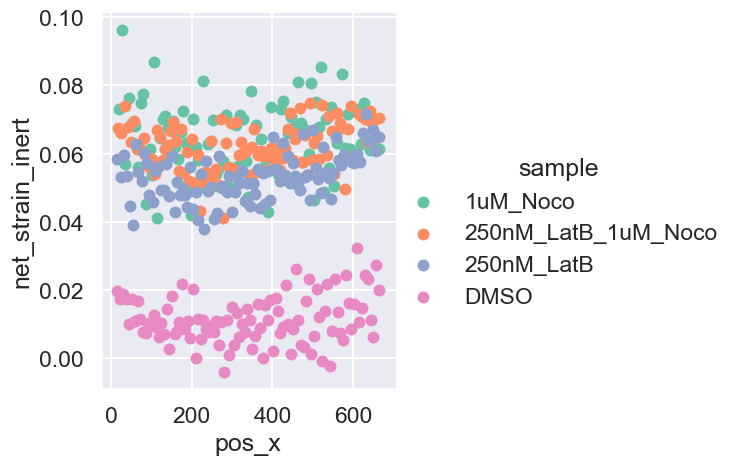

In [21]:
g = sns.lmplot(data=df_20231012_inlet,
               x='pos_x', y='net_strain_inert',
               hue='sample', palette='Set2',
               x_bins=100, x_estimator=np.median, fit_reg=False, ci=None,
               facet_kws={'sharey': True})
# g.refline(x=x0, markersize=0)
plt.show()

In [22]:
filename = "20231012_hl60_latb_noco_inlet.tsv"
df_20231012_inlet.to_csv(os.path.join(data_exports, "20231012_HL60_LatB_Noco", filename),
                         sep='\t')
print("Done")

Done
